# Exploratory Data Analysis

In [63]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
#get and print current directory
cwd = os.getcwd()
cwd

'C:\\Work\\Kaggle\\Planet\\kaggle_UnderstandingAmazonFromSpace'

In [51]:
#open data from current directory. Should work with any direcotry path
with open(os.path.join(cwd, "data", "train.csv")) as file:
    tagged_df = pd.read_csv(file)
tagged_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [52]:
#split the tags into new rows
tagged_df = pd.DataFrame(tagged_df.tags.str.split(' ').tolist(), index=tagged_df.image_name).stack()
tagged_df = tagged_df.reset_index()[[0, 'image_name']] # dataframe with two columns
tagged_df.columns = ['tags', 'image_name'] # rename columns
tagged_df.set_index('image_name', inplace=True) # rest index to image_name again

#create dummy variables for each tag
tagged_df = pd.get_dummies(tagged_df['tags']) # creates dummy rows
tagged_df = tagged_df.groupby(tagged_df.index).sum() # adds dummy rows together by image_name index
tagged_df.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
train_1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
train_10,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1
train_100,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
train_1000,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


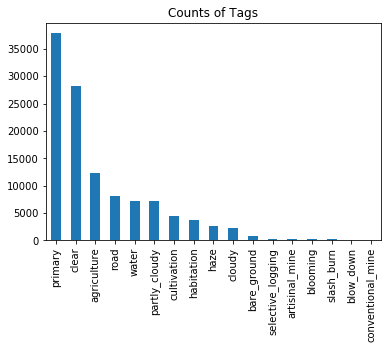

primary              37840
clear                28203
agriculture          12338
road                  8076
water                 7262
partly_cloudy         7251
cultivation           4547
habitation            3662
haze                  2695
cloudy                2330
bare_ground            859
selective_logging      340
artisinal_mine         339
blooming               332
slash_burn             209
blow_down              101
conventional_mine      100
dtype: int64

In [71]:
#Barplot of tag counts
%matplotlib inline
tagged_df.sum().sort_values(ascending=False).plot.bar(title="Counts of Tags")
plt.show()
tagged_df.sum().sort_values(ascending=False)